## Inverting a dispersion curve

The following script runs an inversion of a digitised dispersion curve. The example follows a Nelder Mead inversion in O'Neill et al. 2024, which is reproducible. 

Following that inversion, we invoke a MCMC inversion, which is statistical, and thus varies each time. The latter is used to constrain a posteri velocity distributions.

First we input the filename of seismic data file, and the dispersion file (here very originally called 'figname'). The latter will be used as a prefix for figures later. 

In [ ]:
from FTANos import *
import numpy as np
import matplotlib.pyplot as plt


sfile = "example_trace.sac"

figname = sfile +".disp"


Next we create a velocity array in the standard CPS/Disba format (thickness (km), Vp (km/s), Vs (km/s) and rho (g/cm3))

This will be used/varied for initial conditions in the Nelder Mead inversion approach.



In [ ]:
velMod =  np.array(  [
					[2.0e-3, 0.80, 1.00, 1.00],
					[2.0e-3, 0.80, 1.00, 1.00],
					[2.0e-3, 0.80, 1.00, 1.00],
					[2.0e-3, 0.80, 1.00, 1.00],
					[2.0e-3, 0.80, 1.00, 1.00],
					[2.5e-3, 0.80, 1.00, 1.00],
					[2.5e-3, 1.80, 1.00, 1.50],
					[2.5e-3, 1.80, 1.00, 1.50],
					[2.5e-3, 1.80, 1.50, 1.50],
					[5.0e-3, 1.80, 1.50, 1.50],
					[5.0e-3, 1.80, 1.50, 1.50],
					[5.0e-3, 1.80, 1.50, 1.50],
					[5.0e-3, 2.80, 1.50, 1.50],
					[5.0e-3, 2.80, 1.50, 1.50],
					[5.0e-3, 2.80, 1.50, 1.50],
					[5.0e-3, 2.80, 1.50, 1.50],
					])


Now we can create a little repeating depth profile to plot up the velocity layers:

In [ ]:
d0 = np.array([])
d1 = np.cumsum(velMod[:,0])
d2 = d1-np.copy(velMod[:,0])

for i in range(len(d1)):
    d0 = np.append(d0,d2[i])
    d0 = np.append(d0,d1[i])

d0 *=1e3


### Run FTANos inversion using Nelder-Mead simplex method

We define a maximum velocity here (1.5km/s) beyond which models are penalised.
This first command below initialises the model. We supply the Velocity Model velMod (defined previously),  and a maximum velocity penalty term *max_vs*,as well as the dispersion file name (set above):


In [ ]:
out_inv = FTAN_Invert(fig_file=figname,velMod=velMod,max_vs=1.5)


Now we run the inversion. The Nelder Mead instantiation runs 18 initial starting conditions by default.

This can be changed for more robust runs covering more starting conditions, see descriptions in main code. 

In [ ]:
velModa, Vs_a, std_a, best, disp, disp_obs = out_inv.Amoeba_crawl()


This routine exports a number of outputs. velModa is the optimal velocity model based on the ensemble of inversion. *Vs_a* above is the shear wave velocity profile, and *std_a* is its standard deviation from the Nelder-Mead runs. *disp* and *disp_obs* are tuples holding the calculated solution dispersion curve (disp) and the original digitised dispersion curve (disp_obs). The first term in the tuple (disp[0]) are the periods in s, the second term (disp[1]) are the group velocities (km/s).

### Plotting

One could plot these results with the following code:

In [ ]:
plt.subplot(121)
V_plot = np.repeat(Vs_a,2)
plt.fill_betweenx(d0,V_plot-np.repeat(std_a,2),V_plot+np.repeat(std_a,2),alpha=0.5,color="xkcd:mint green")
plt.plot(V_plot,d0,label=str(np.min(best)),alpha=1.0,linewidth=2.0,color="xkcd:black")
plt.legend(fontsize=7)
plt.ylim(np.max(d0),0)
plt.xlim(0,3.5)


plt.subplot(122)
plt.plot(disp[0],disp[1],linewidth=2.0,color="xkcd:black",label="Inversion")
plt.plot(disp_obs[0],disp_obs[1],linewidth=2.0,color="xkcd:black",linestyle="--",label="Data")
plt.legend()

plt.savefig("NelderMead_Simplex_suite.png")
plt.show()




The figure should look something (!) like this:

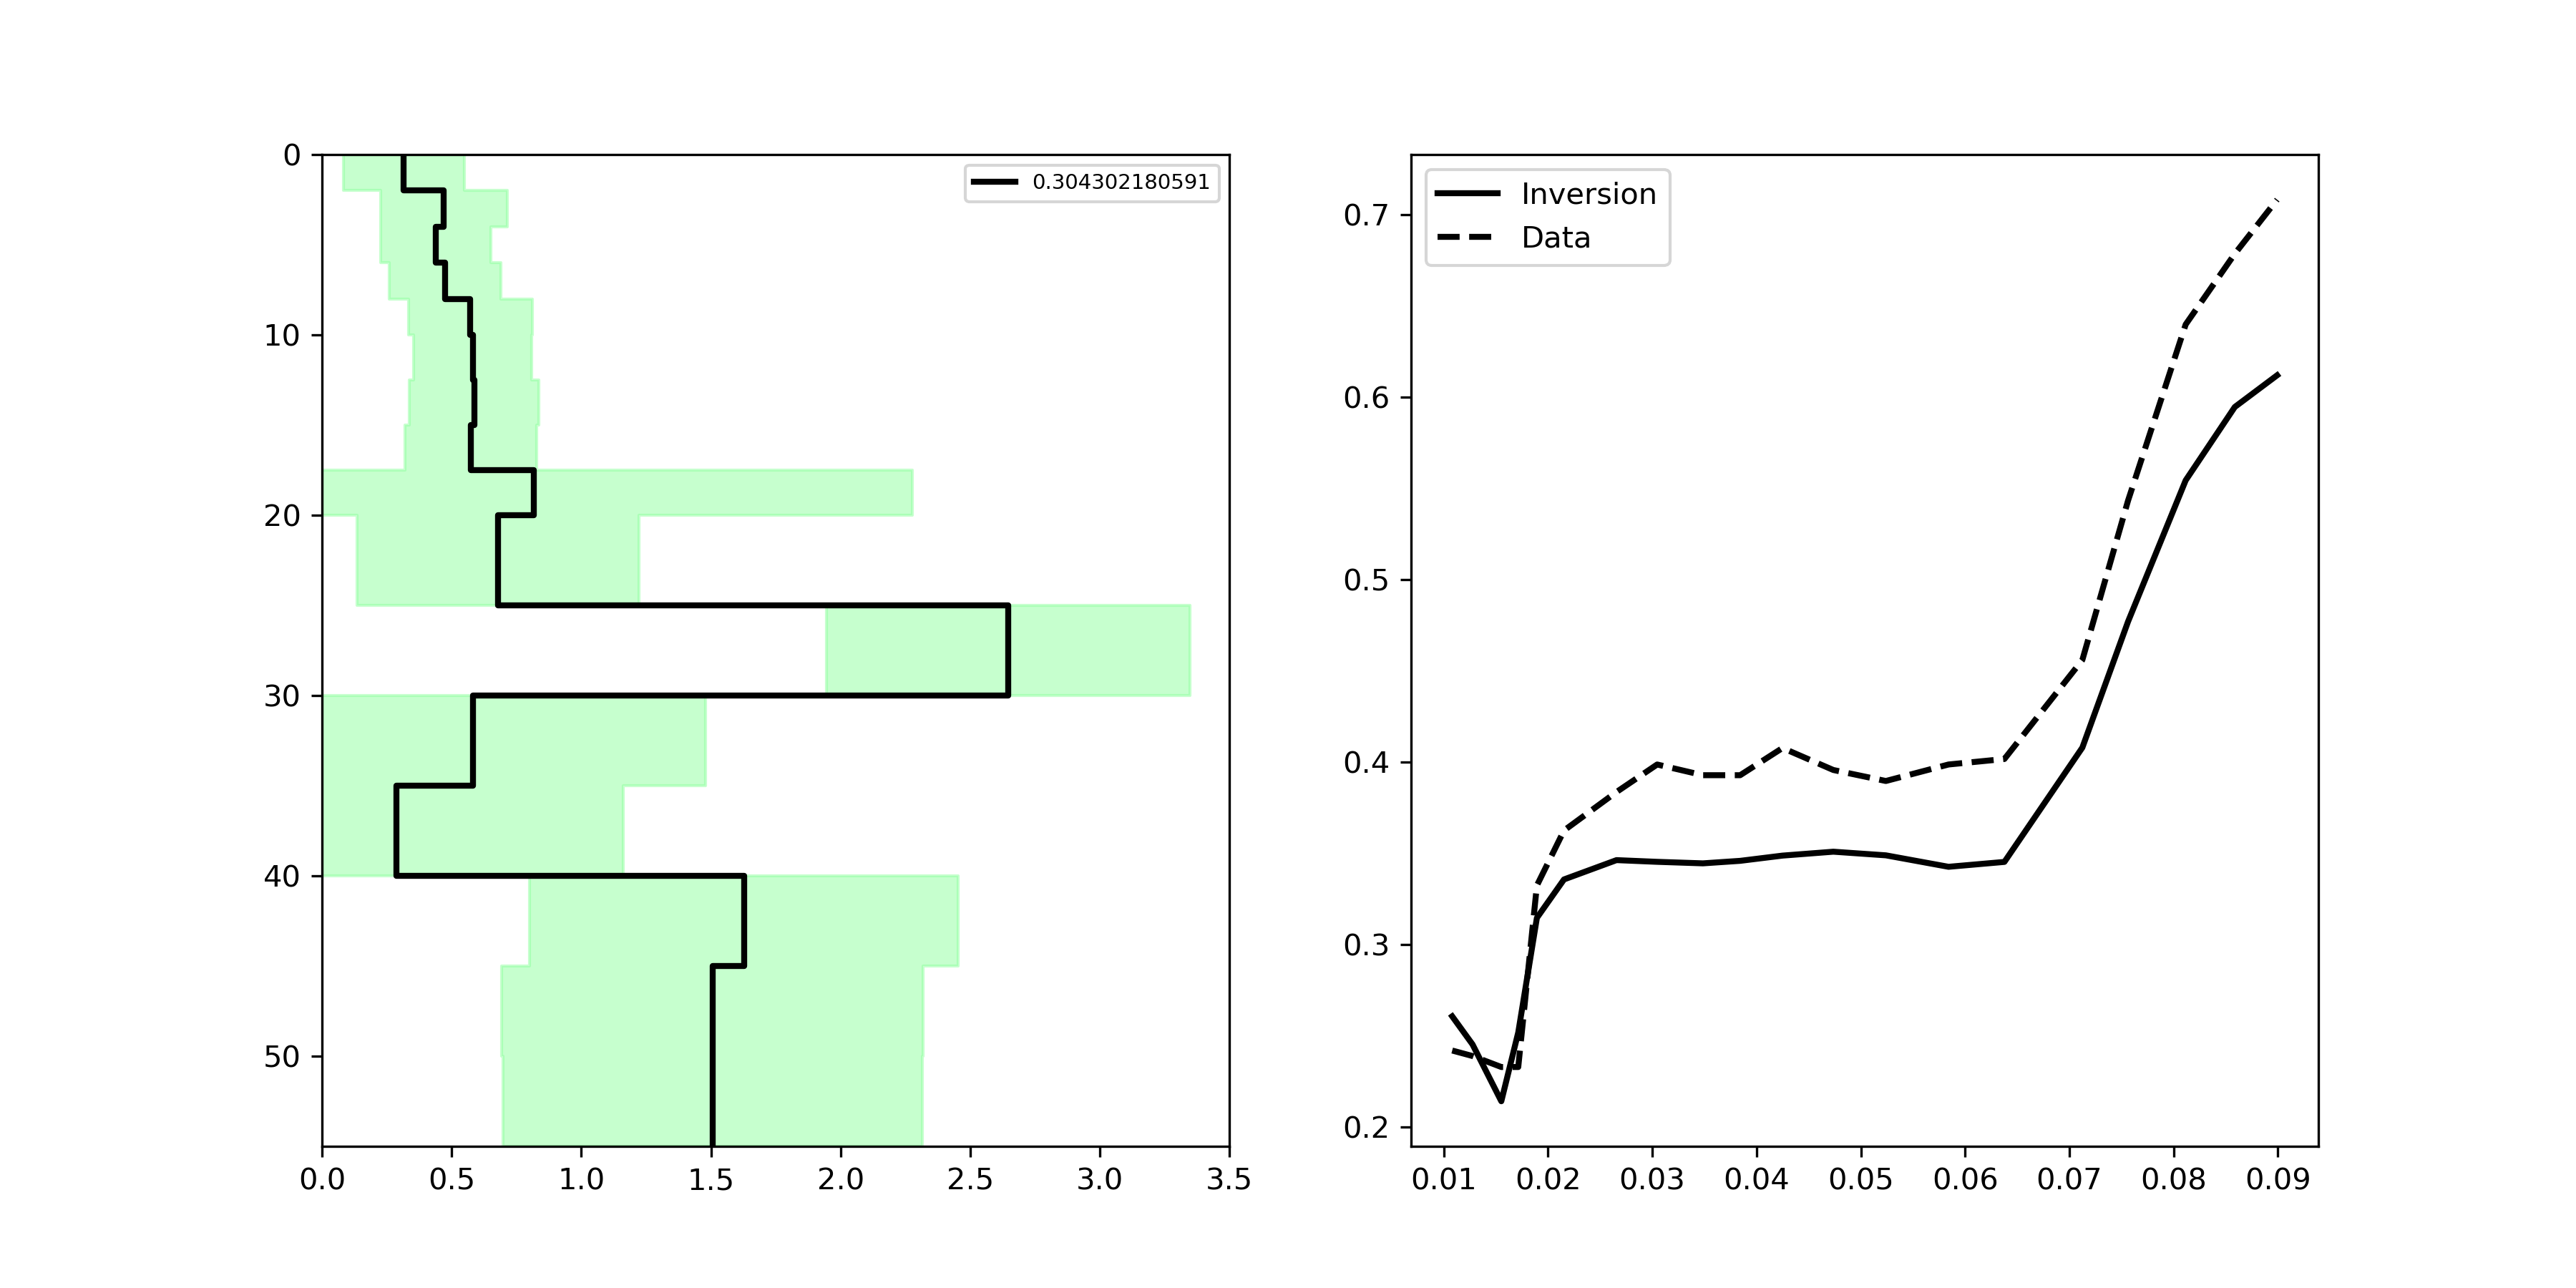

### Saving outputs

Outputs can then be saved as follows:

In [ ]:
c = np.zeros( (len(std_a),1) ) #Here we need to stack the standard deviation onto the veloity model for saving.
c[:,0] = std_a
np.savetxt("best_velMod.dat",np.hstack((velModa,c)))
np.savetxt("best_disp_curves.dat",np.c_[disp_obs[0],disp_obs[1],disp[0],disp[1]])


## Markov Chain Monte Carlo Inversion

Optionally we can also run a Markov-Chain Monte Carlo inversion. This can be performed initially, or as a second step after the initial Nelder-Mead simplex inversion has converged on a sensible model. The advantage of the latter is that a sensible step size can be applied to map out the *a posteri* distributions. Using this as an initial inversion requires large step sizes to cover the parameter space, which may not match the a priori distribution of uncertainty. Use with nuance. 

Note the dispersion curve/figures names are supplied as per the Nelder Mead example, as is the initial velocity model. 

However, new MCMC parameters include the option for a burn-in period (this is to allow convergence before the algorithm explores the *a posteri* solution space). The number of post-burn-in iterations is set by *n_ite*, and should be large for accurate uncertainty determination. Lastly the step_size governs the random walk the MCMC performs as it searches the solution size. Ultimately this maps back to *a priori* uncertainties in the data/model.



In [ ]:
out_inv = FTAN_Invert(fig_file=figname,velMod=velModa,n_burn=1,n_ite=2000,step_size=0.1)
vel_mod, L1s = out_inv.go_for_a_walk()


Note the velocity model is for an ensemble
The output velocity model can be imaged similarly to the previous example. 
The velocity model is stored in this step in the file "MCMC_results.dat"
The format is d1 (depth, mean_Vs (ie. mean of ensemble),stdv (standard deviation of ensemble), lowest_Vs (ie. best fit).

If the ensemble model can be forward modelled, the resulting dispersion curve is saved in the file *"mcmc_inversion_result.dat"*.

The optimal dispersion curve will likewise be archived in a file called *"mcmc_optimal_model_dispersion.dat"*.

The routine will create an output image of the velocity structure, dispersion curve, and L1 norm convergence statistics, unimaginatively called "results.png". Might want to change the name manually between runs. 

You should get something like this:


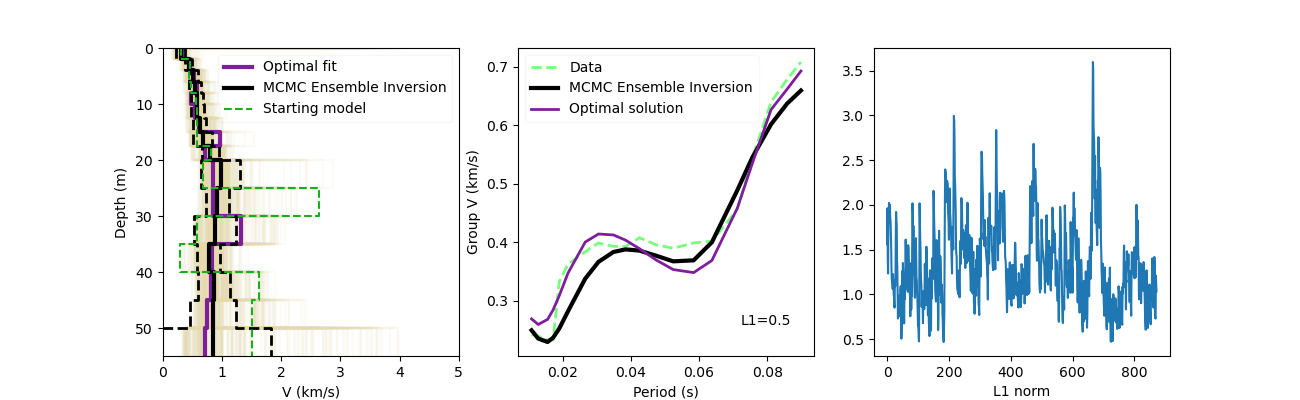